In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');

#import plotsettings 
#publishable = plotsettings.Set('Cell') 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

# Useful Functions

In [2]:
def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):

    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    
    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()
    
    if Plot:
        single_mut_data_mean.plot(x='Position', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        plt.xlabel(Mut_name+' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical',fontsize=15)
    
    return single_mut_data_mean

def plot_double_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    Mut_type_str = Mut_type+'|'+Mut_type
    
    data['Mutation Type'].fillna('', inplace=True)
    double_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type_str)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    double_mut_data['Position'] = double_mut_data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y.split(':')[1], x.split('|'))))
    double_mut_data_mean = double_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    double_mut_map = np.empty((Ng,Ng))
    double_mut_map[:] = np.nan
    for n in range(len(double_mut_data_mean)):
        pos = double_mut_data_mean['Position'].iloc[n]
        Positions = map(lambda x: int(x)-1, pos.split('|'))
        double_mut_map[Positions[1],Positions[0]] = double_mut_data_mean['Delta ABA (kBT)'].iloc[n]
        
    if Plot:    
        plt.figure()
        sns.heatmap(double_mut_map, cmap='coolwarm',cbar=True,vmin=0,vmax=double_mut_data_mean['Delta ABA (kBT)'].max())
        plt.xlabel(Mut_name+' 1', fontsize=15)
        plt.ylabel(Mut_name+' 2', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+0.5));
        ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+0.5));
    
    return double_mut_data_mean, double_mut_map

def make_block_ID(MM_pos_list):
    
    bi = MM_pos_list[0]
    bf = MM_pos_list[-1]
    block = np.arange(bi,bf+1)
    if (len(block)!=len(MM_pos_list)) or np.any(block!=np.array(MM_pos_list)):
        return ''
    return '|'.join(map(str, [bi, bf]))

def plot_block_mm_ABA(data, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: map(lambda y: int(y.split(':')[1]), x.split('|')))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    block_mm_map = np.empty((Ng,Ng))
    block_mm_map[:] = np.nan
    for n in range(len(block_mm_data_mean)):
        pos = block_mm_data_mean['Position'].iloc[n]
        Positions = map(lambda x: int(x)-1, pos.split('|'))
        block_mm_map[Positions[0],Positions[1]] = block_mm_data_mean['Delta ABA (kBT)'].iloc[n]

    if Plot:
        plt.figure()
        sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=0,vmax=block_mm_data_mean['Delta ABA (kBT)'].max())
        plt.xlabel('Block end', fontsize=15)
        plt.ylabel('Block start', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+0.5));
        ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+0.5));
    
    block_start_mm_data = block_mm_data_mean.set_index('Position').groupby(lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index':'Block start'})
    
    if Plot:
        block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        plt.xlabel('Block start', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name+' - Noncanonical',fontsize=15)
    
    return block_mm_data_mean, block_mm_map, block_start_mm_data

def plot_mut_PAM_ABA(data, data_name='Finkelstein Data', Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    data['Alignment'].fillna('', inplace=True)
    NonCanonical = data[(data['Canonical']==False)&(data['Alignment']!='')&(data['Mutation Type']=='')][['PAM', 'Delta ABA (kBT)', 'Uncertainty']].groupby('PAM').mean()
    
    if Plot:
        plt.figure(figsize=(20,6))
        plt.bar(np.arange(len(NonCanonical)), NonCanonical['Delta ABA (kBT)'])
        ax = plt.gca()
        ax.set_xticks(np.arange(len(NonCanonical))+0.5);
        ax.set_xticklabels(NonCanonical.index, rotation='vertical');
        plt.xlabel('PAM', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
    
    return NonCanonical

# Loading the data

In [3]:
Path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
filename_1 = 'cas9-target-e-replicate-1-delta-abas-processed.csv'
filename_2 = 'cas9-target-d-replicate-1-delta-abas-processed.csv'
filename_3 = 'cas12a-target-d-replicate-1-delta-abas-processed.csv'
filename_4 = 'cas12a-target-d-replicate-2-delta-abas-processed.csv'
data_cas9_e1 = pd.read_csv(Path+filename_1)
data_cas9_d1 = pd.read_csv(Path+filename_2)
data_cas12a_d1 = pd.read_csv(Path+filename_3)
data_cas12a_d2 = pd.read_csv(Path+filename_4)

# Cas 9 target e 

## Single Mutation

In [4]:
Single_r_cas9_e1 = plot_single_mut_ABA(data_cas9_e1, Mut_type='r', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep'})
Single_i_cas9_e1 = plot_single_mut_ABA(data_cas9_e1, Mut_type='i', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - ins'})
Single_d_cas9_e1 = plot_single_mut_ABA(data_cas9_e1, Mut_type='d', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - del'})
Single_r_NC_cas9_e1 = plot_single_mut_ABA(data_cas9_e1, Mut_type='r', Canonical=False, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep NC'})
Single_cas9_e1 = ((Single_r_cas9_e1.merge(Single_i_cas9_e1, on='Position', how='outer')).merge(Single_d_cas9_e1, on='Position', how='outer')).merge(Single_r_NC_cas9_e1, on='Position', how='outer')

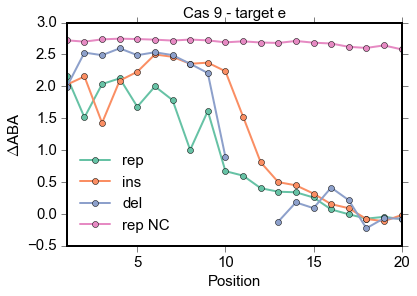

In [5]:
Single_cas9_e1.plot(x='Position', y=['Delta ABA (kBT) - rep', 'Delta ABA (kBT) - ins', 'Delta ABA (kBT) - del', 'Delta ABA (kBT) - rep NC']
                    , marker='o', linewidth=2)
plt.ylabel('$\Delta$ABA', fontsize=15)
plt.title('Cas 9 - target e',fontsize=15)
plt.legend(['rep', 'ins', 'del', 'rep NC'], fontsize=15, loc=3)


## Double Mutation

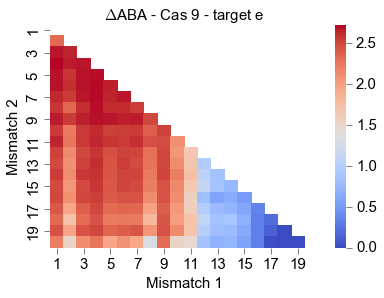

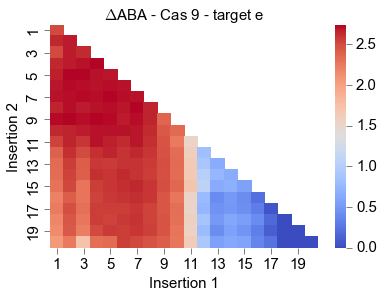

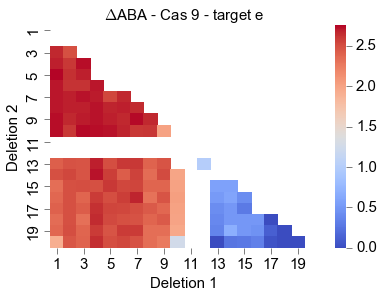

In [6]:
_, double_r_cas9_e1 = plot_double_mut_ABA(data_cas9_e1, Mut_type='r', data_name='Cas 9 - target e', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas9_e1, Mut_type='i', data_name='Cas 9 - target e', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas9_e1, Mut_type='d', data_name='Cas 9 - target e', Canonical=True, Plot=True)

## Mismatch Blocks

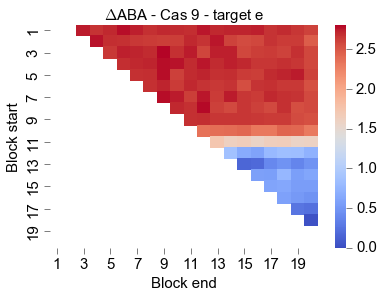

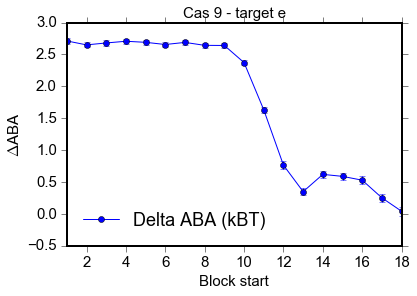

In [7]:
_, block_cas9_e1, block_start_cas9_e1 = plot_block_mm_ABA(data_cas9_e1, data_name='Cas 9 - target e', Canonical=True, Plot=True)

## PAM Mutations

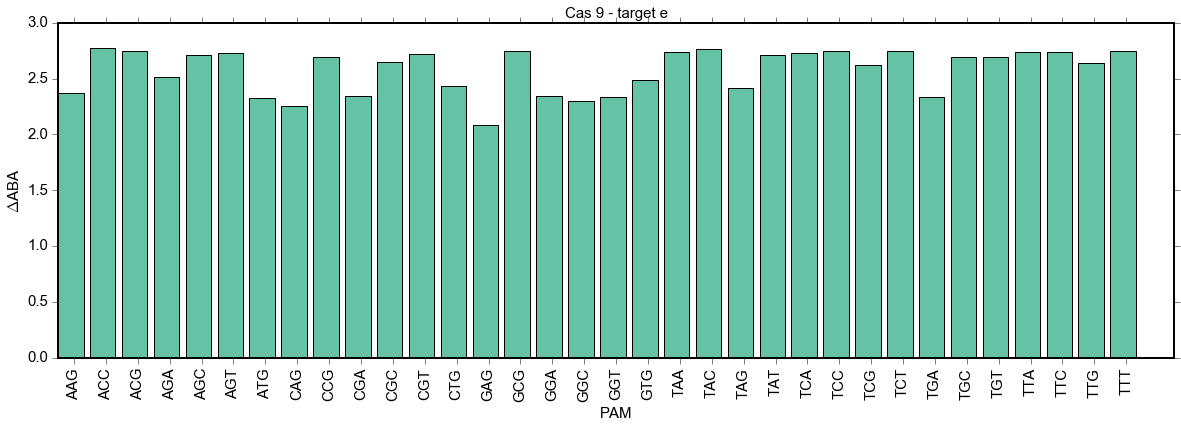

In [8]:
Mut_PAM_cas9_e1 = plot_mut_PAM_ABA(data_cas9_e1, data_name='Cas 9 - target e', Plot=True)

# Cas 9 target d 

## Single Mutation

In [9]:
Single_r_cas9_d1 = plot_single_mut_ABA(data_cas9_d1, Mut_type='r', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep'})
Single_i_cas9_d1 = plot_single_mut_ABA(data_cas9_d1, Mut_type='i', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - ins'})
Single_d_cas9_d1 = plot_single_mut_ABA(data_cas9_d1, Mut_type='d', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - del'})
Single_r_NC_cas9_d1 = plot_single_mut_ABA(data_cas9_d1, Mut_type='r', Canonical=False, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep NC'})
Single_cas9_d1 = ((Single_r_cas9_d1.merge(Single_i_cas9_d1, on='Position', how='outer')).merge(Single_d_cas9_d1, on='Position', how='outer')).merge(Single_r_NC_cas9_d1, on='Position', how='outer')

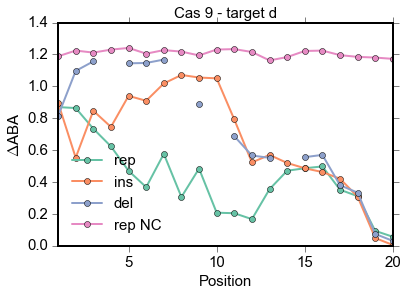

In [10]:
Single_cas9_d1.plot(x='Position', y=['Delta ABA (kBT) - rep', 'Delta ABA (kBT) - ins', 'Delta ABA (kBT) - del', 'Delta ABA (kBT) - rep NC']
                    , marker='o', linewidth=2)
plt.ylabel('$\Delta$ABA', fontsize=15)
plt.title('Cas 9 - target d',fontsize=15)
plt.legend(['rep', 'ins', 'del', 'rep NC'], fontsize=15, loc=3)


## Double Mutation

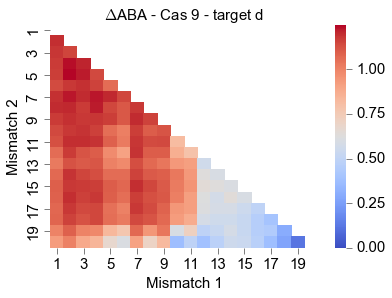

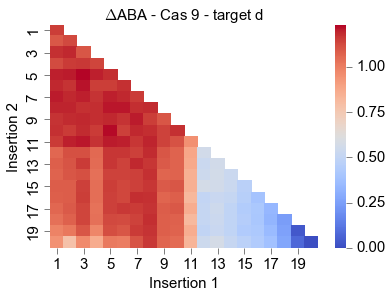

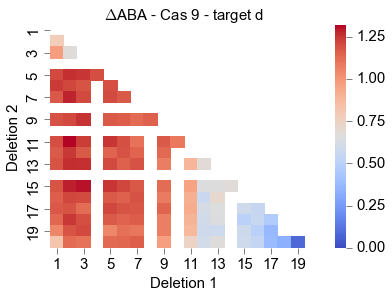

In [11]:
_, double_r_cas9_d1 = plot_double_mut_ABA(data_cas9_d1, Mut_type='r', data_name='Cas 9 - target d', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas9_d1, Mut_type='i', data_name='Cas 9 - target d', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas9_d1, Mut_type='d', data_name='Cas 9 - target d', Canonical=True, Plot=True)

## Mismatch Blocks

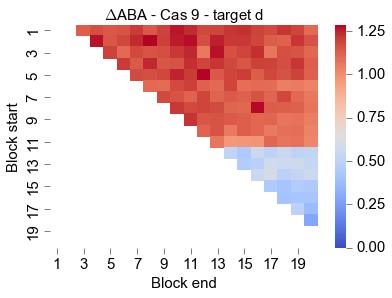

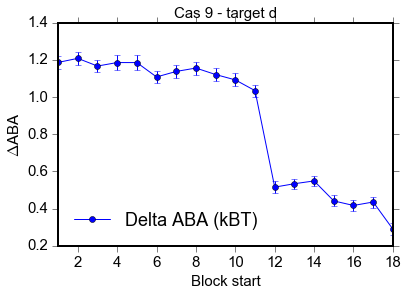

In [12]:
_, block_cas9_d1, block_start_cas9_d1 = plot_block_mm_ABA(data_cas9_d1, data_name='Cas 9 - target d', Canonical=True, Plot=True)

## PAM Mutations

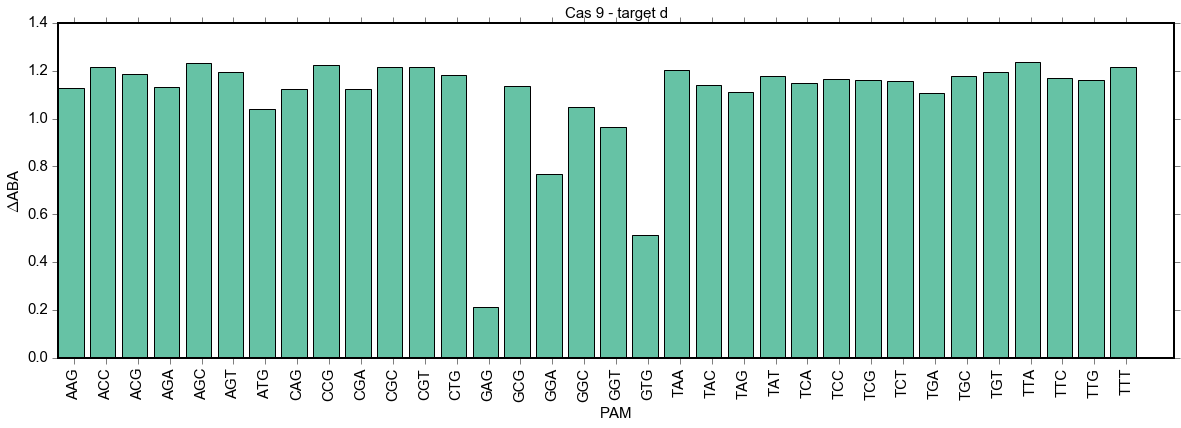

In [13]:
Mut_PAM_cas9_d1 = plot_mut_PAM_ABA(data_cas9_d1, data_name='Cas 9 - target d', Plot=True)

# Compare target e with target d (Cas9)

Here I shift the $\Delta$ABA values in such a way that for each target the non-specific binding has zero ABA.

In [14]:
Max_ABA_cas9_d = np.nanmax(block_cas9_d1)
Max_ABA_cas9_e = np.nanmax(block_cas9_e1)

## Double Mismatches

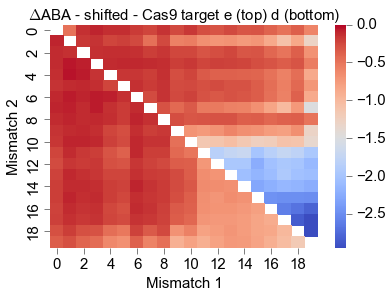

In [15]:
Map_d = np.nan_to_num(double_r_cas9_d1-Max_ABA_cas9_d)
Map_e= np.nan_to_num(double_r_cas9_e1-Max_ABA_cas9_e).T 
Map = Map_e + Map_d
Min = np.min(Map)
np.fill_diagonal(Map, np.nan)
sns.heatmap(Map, cmap='coolwarm',cbar=True, vmin=Min, vmax=0);
plt.xlabel('Mismatch 1', fontsize=15);
plt.ylabel('Mismatch 2', fontsize=15);
plt.title('$\Delta$ABA - shifted - Cas9 target e (top) d (bottom)',fontsize=15);

## Mismatch Blocks

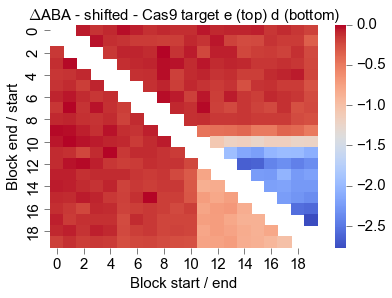

In [16]:
Map_d = np.nan_to_num(block_cas9_d1-Max_ABA_cas9_d).T
Map_e= np.nan_to_num(block_cas9_e1-Max_ABA_cas9_e)
Map = Map_e + Map_d
Min = np.min(Map)
for i in range(20):
    Map[i,i:i+2] = np.nan
    Map[i:i+2,i] = np.nan
sns.heatmap(Map, cmap='coolwarm',cbar=True, vmin=Min, vmax=0);
plt.xlabel('Block start / end', fontsize=15);
plt.ylabel('Block end / start', fontsize=15);
plt.title('$\Delta$ABA - shifted - Cas9 target e (top) d (bottom)',fontsize=15);

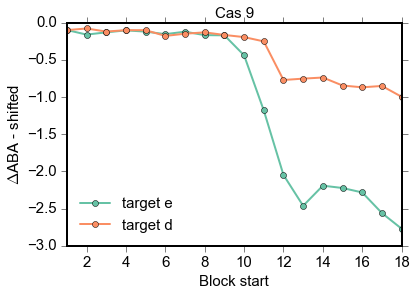

In [17]:
block_start_d = block_start_cas9_d1[['Block start', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'target d'})
block_start_e = block_start_cas9_e1[['Block start', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'target e'})
block_start_d['target d'] = block_start_d['target d']-Max_ABA_cas9_d
block_start_e['target e'] = block_start_e['target e']-Max_ABA_cas9_e
block_start = block_start_d.merge(block_start_e, on='Block start', how='outer')
block_start.plot(x='Block start', y=['target e', 'target d'], marker='o', linewidth=2)
plt.ylabel('$\Delta$ABA - shifted', fontsize=15)
plt.title('Cas 9',fontsize=15)
plt.legend(['target e', 'target d'], fontsize=15, loc=3)

## PAM Mutations

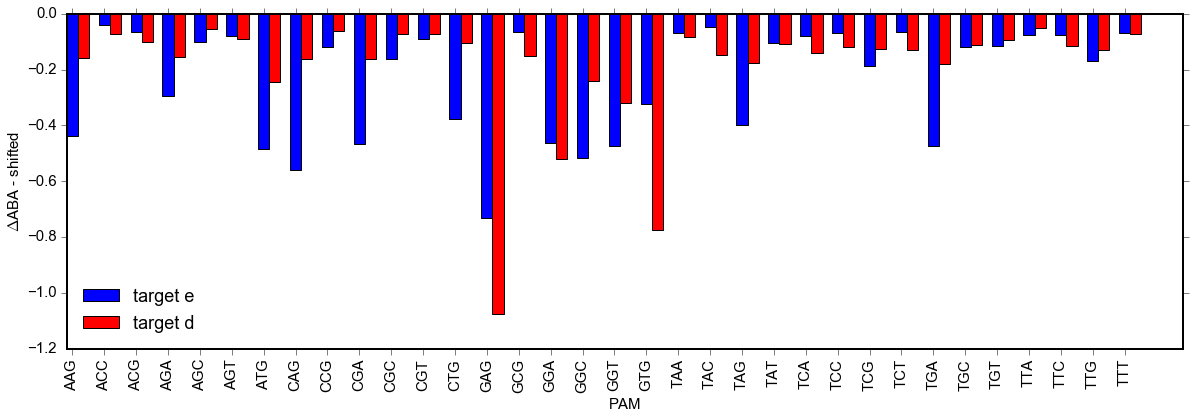

In [18]:
Mut_PAM_d = Mut_PAM_cas9_d1.rename(columns={'Delta ABA (kBT)':'target d'})
Mut_PAM_e = Mut_PAM_cas9_e1.rename(columns={'Delta ABA (kBT)':'target e'})
Mut_PAM_d['target d'] = Mut_PAM_d['target d']-Max_ABA_cas9_d
Mut_PAM_e['target e'] = Mut_PAM_e['target e']-Max_ABA_cas9_e
Mut_PAM = Mut_PAM_d.merge(Mut_PAM_e, left_index=True, right_index=True, how='outer').drop(['Uncertainty_x', 'Uncertainty_y'],axis=1)
plt.figure(figsize=(20,6))
bar_width = 0.35
plt.bar(np.arange(len(Mut_PAM)),Mut_PAM['target e'], width=bar_width, color='b', label='target e')
ax = plt.gca()
ax.bar(np.arange(len(Mut_PAM))+bar_width,Mut_PAM['target d'], width=bar_width, color='r', label='target d')
ax.set_xticks(np.arange(len(Mut_PAM))+0.5*bar_width);
ax.set_xticklabels(Mut_PAM.index, rotation='vertical');
plt.xlabel('PAM', fontsize=15)
plt.ylabel('$\Delta$ABA - shifted', fontsize=15)
plt.ylim([-1.2,0])
ax.legend(loc=3);


# Cas 12a target d replica 1

## Single Mutation

In [19]:
Single_r_cas12a_d1 = plot_single_mut_ABA(data_cas12a_d1, Mut_type='r', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep'})
Single_i_cas12a_d1 = plot_single_mut_ABA(data_cas12a_d1, Mut_type='i', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - ins'})
Single_d_cas12a_d1 = plot_single_mut_ABA(data_cas12a_d1, Mut_type='d', Canonical=True, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - del'})
Single_r_NC_cas12a_d1 = plot_single_mut_ABA(data_cas12a_d1, Mut_type='r', Canonical=False, Plot=False)[['Position', 'Delta ABA (kBT)']].rename(columns={'Delta ABA (kBT)':'Delta ABA (kBT) - rep NC'})
Single_cas12a_d1 = ((Single_r_cas12a_d1.merge(Single_i_cas12a_d1, on='Position', how='outer')).merge(Single_d_cas12a_d1, on='Position', how='outer')).merge(Single_r_NC_cas12a_d1, on='Position', how='outer')

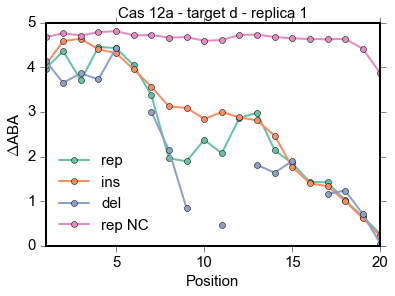

In [20]:
Single_cas12a_d1.plot(x='Position', y=['Delta ABA (kBT) - rep', 'Delta ABA (kBT) - ins', 'Delta ABA (kBT) - del', 'Delta ABA (kBT) - rep NC']
                    , marker='o', linewidth=2)
plt.ylabel('$\Delta$ABA', fontsize=15)
plt.title('Cas 12a - target d - replica 1',fontsize=15)
plt.legend(['rep', 'ins', 'del', 'rep NC'], fontsize=15, loc=3)


## Double Mutation

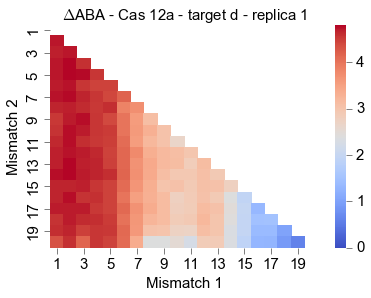

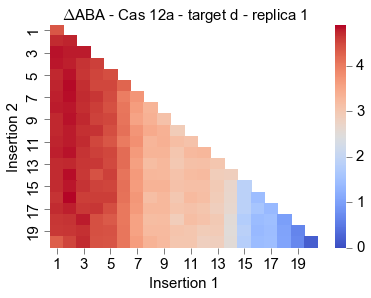

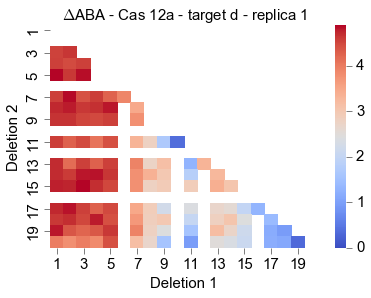

In [21]:
_, double_r_cas12a_d1 = plot_double_mut_ABA(data_cas12a_d1, Mut_type='r', data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas12a_d1, Mut_type='i', data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)
_, _ = plot_double_mut_ABA(data_cas12a_d1, Mut_type='d', data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)

## Mismatch Blocks

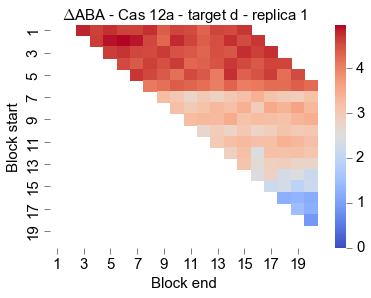

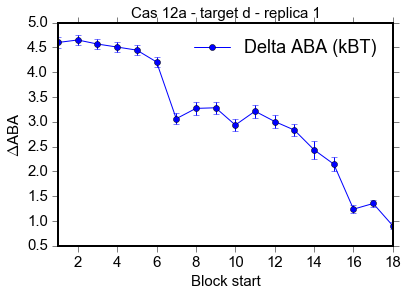

In [22]:
_, block_cas12a_d1, block_start_cas9_d1 = plot_block_mm_ABA(data_cas12a_d1, data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)

## PAM Mutations

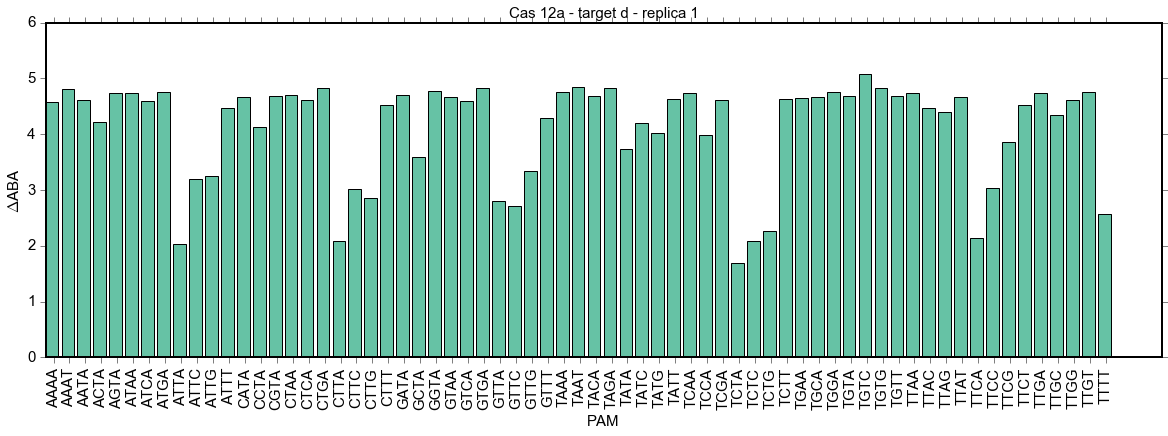

In [23]:
Mut_PAM_cas12a_d1 = plot_mut_PAM_ABA(data_cas12a_d1, data_name='Cas 12a - target d - replica 1', Plot=True)